In [33]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import statsmodels.api as sm
from typing import List
import warnings
warnings.filterwarnings("ignore")


Clean the data. Keep only the sites with sufficient valid data.

In [ ]:
data = pd.read_stata("AER20090377_FinalData.dta")

# Filter by year and valid data
data = data[data['year'] < 2004]
data = data[data['valid'] >= 9]
data = data[data['month'].isin([6, 7, 8])]

# keep only monitor-years in which 75% of days have observations (69 days out of 92)
data = data[['fips', 'site_id', 'day', 'month', 'year']]
data.drop_duplicates(inplace=True)
data['NumDays'] = data.groupby(['fips', 'site_id', 'year'])['day'].transform('count')
data = data[data['NumDays'] >= 69]
data = data[['fips', 'site_id', 'year']]
data = data.drop_duplicates()
data = data.sort_values(by=['fips', 'site_id', 'year'])
data.to_stata('SummerList.dta', write_index=False)

data = pd.read_stata("AER20090377_FinalData.dta")
data = data[data['valid'] >= 9]
data = data[[i for i in data.columns if '_merge' not in i]]
data = pd.merge(data, pd.read_stata('SummerList.dta'), how='inner', on=['fips', 'site_id', 'year'])
data.to_stata('temp.dta')

In [ ]:
# keep only the sites having 15-year valid data
data = data[['fips', 'site_id', 'year', 'ozone_max']]
data = (
    data.groupby(['fips', 'site_id', 'year'], as_index=False)
    .agg({'ozone_max': 'mean'})
)
data['NumYear'] = data.groupby(['fips', 'site_id'])['year'].transform('count')
data = data[data['NumYear'] == 15]
data = data[['fips', 'site_id']]
data = data.drop_duplicates().sort_values(by=['fips', 'site_id'])
data.to_stata('FullHistoryMonitors.dta') # all valid fips-site

In [ ]:
df_tmp = pd.read_stata('temp.dta')

df_tmp.sort_values(by=['fips', 'site_id'])
df_tmp = pd.merge(df_tmp,pd.read_stata('FullHistoryMonitors.dta'), how='inner', on=['fips', 'site_id'])
df_tmp.sort_values('fips',inplace=True)

# Drop monitors in untreated counties that border treated counties to avoid the effect of neighbor counties
df_tmp = pd.merge(df_tmp, pd.read_stata('AER20090377_NeighborData.dta'), on='fips', how='left', indicator=True)
df_tmp = df_tmp[df_tmp['_merge'] == 'left_only']
df_tmp.drop(columns=['_merge'], inplace=True)

# If a site is treated by both CARB and RFG, regard it as a member of CARB group
df_tmp.loc[df_tmp.treat_CARB!=0, 'treat_rfg'] = 0
df_tmp.to_stata('temp.dta')

del(df_tmp)

---

Create weather variables and interaction terms


In [ ]:
data = pd.read_stata('temp.dta')

# Day of week (DOW) and cross temperature effects
data['DOW'] = pd.to_datetime(data['Date']).dt.dayofweek

# Interaction terms between DOW and weather data.
# Must drop first in order to avoid multi coliniearity problem (huge variance and irreverxible)
dow_dummies = pd.get_dummies(data['DOW'], prefix='_DM', drop_first=True) 
for col in dow_dummies.columns:
    data[f'{col[:3]+col[4:]}'] = dow_dummies[col] * data['TempMax']

dow_dummies = pd.get_dummies(data['DOW'], prefix='_Dm', drop_first=True)
for col in dow_dummies.columns:
    data[f'{col[:3]+col[4:]}'] = dow_dummies[col] * data['TempMin']

dow_dummies = pd.get_dummies(data['DOW'], prefix='_Dr', drop_first=True)
for col in dow_dummies.columns:
    data[f'{col[:3]+col[4:]}'] = dow_dummies[col] * data['Rain']

dow_dummies = pd.get_dummies(data['DOW'], prefix='_Ds', drop_first=True)
for col in dow_dummies.columns:
    data[f'{col[:3]+col[4:]}'] = dow_dummies[col] * data['Snow']

# Day of Year (DOY)
data['DOY'] = pd.to_datetime(data['Date']).dt.dayofyear

# Polynomials of temperatures
data['TempMax1'] = data['TempMax']
data['TempMax2'] = data['TempMax']**2
data['TempMax3'] = data['TempMax']**3
data['TempMin1'] = data['TempMin']
data['TempMin2'] = data['TempMin']**2
data['TempMin3'] = data['TempMin']**3
data['TempMaxMin'] = data['TempMax'] * data['TempMin']
data['Rain1'] = data['Rain']
data['Rain2'] = data['Rain']**2
data['Snow1'] = data['Snow']
data['Snow2'] = data['Snow']**2
data['RainTempMax'] = data['Rain'] * data['TempMax']

In [ ]:
data = data.sort_values(by=['fips', 'site_id', 'Date'])

# Lagging term of Temperature
data['TempMaxL1'] = data.groupby(['fips', 'site_id'])['TempMax'].shift(1)
data['TempMinL1'] = data.groupby(['fips', 'site_id'])['TempMin'].shift(1)
data['TempMaxL1'] = data['TempMaxL1'].fillna(np.nan)
data['TempMinL1'] = data['TempMinL1'].fillna(np.nan)

# Interaction terms between temeratures variables
data['TempMaxMaxL1'] = data['TempMax'] * data['TempMaxL1']
data['TempMaxMinL1'] = data['TempMax'] * data['TempMinL1']

# Interaction terms between DOY and Temperatures
data['DOY'] = data['Date'].dt.dayofyear
temperature_vars = [i for i in data.columns if i>="TempMax1" and i <= "TempMaxMinL1"] 
for var in temperature_vars:
    data[f'DOY{var}'] = data['DOY'] * data[var]

data = data[data['Date'].dt.month.isin([6, 7, 8])]
data.to_stata('temp.dta')

Additional variables: incomes and log ozone

In [ ]:
# Income
temp = pd.read_stata('temp.dta')
income_data = pd.read_stata('AER20090377_IncomeData.dta')
temp = temp.sort_values(by=['state_code', 'county_code', 'year'])
data = pd.merge(temp, income_data, on=['state_code', 'county_code', 'year'], how='inner', indicator=True)
data = data[data['_merge'] == 'both']
data = data.drop(columns=['_merge'])

# log ozone
data = data[(data['ozone_max'] != 0) & (data['epa_8hr'] != 0)]
data.dropna(subset=[i for i in data.columns if i>="TempMax1" and i <= "TempMaxMinL1"] +['income'], inplace=True)
data['lozone_max'] = np.log(data['ozone_max'])
data['lozone_8hr'] = np.log(data['epa_8hr'])
data.drop(columns=['treated_neighbor'],inplace=True)

Create census region dummies and interactions. Create time trend and interactions

In [9]:
data['region'] = None
data['division'] = None

region_map = {
    1:3,
    2:4,
    4:4,
    5:3,
    6:4,
    8:4,
    9:1,
    10:3,
    11:3,
    12:3,
    13:3,
    15:4,
    16:4,
    17:2,
    18:2,
    19:2,
    20:2,
    21:3,
    22:3,
    23:1,
    24:3,
    25:1,
    26:2,
    27:2,
    28:3,
    29:2,
    30:4,
    31:2,
    32:4,
    33:1,
    34:1,
    35:4,
    36:1,
    37:3,
    38:2,
    39:2,
    40:3,
    41:4,
    42:1,
    44:1,
    45:3,
    46:2,
    47:3,
    48:3,
    49:4,
    50:1,
    53:4,
    54:3,
    55:2,
    56:4
}

data['region'] = data['state_code'].map(region_map)

In [ ]:
# interactions terms and corresponding dummy variables
dow_dummies = pd.get_dummies(data[['year', 'region']], columns=['year', 'region'], prefix=['_RY', '_RY'], drop_first=True)
for col in dow_dummies.columns:
    data[f'{col[:3]+col[4:]}'] = dow_dummies[col]

dow_dummies = pd.get_dummies(data[['DOW', 'region']], columns=['DOW', 'region'], prefix=['_RW', '_RW'], drop_first=True)
for col in dow_dummies.columns:
    data[f'{col[:3]+col[4:]}'] = dow_dummies[col]

dow_dummies = pd.get_dummies(data[['region', 'DOY']], columns=['region', 'DOY'], prefix=['_RD', '_RD'], drop_first=True)
for col in dow_dummies.columns:
    data[f'{col[:3]+col[4:]}'] = dow_dummies[col]

# Transform date to float
data['DateS'] = (data["Date"] - pd.to_datetime("1960-01-01")).dt.days / 365
# Polynomial term of date
data['DateS2'] = data["DateS"] ** 2

In [ ]:
# Update dummy viariables of treatments
data = data.drop(columns=['RVPCty', 'RFGCty', 'CARBCty'])

data['RVPCty'] = data.groupby('fips')['treat_rvpII'].transform('max')
data['RFGCty'] = data.groupby('fips')['treat_rfg'].transform('max')

# Add the group with sites treated by both RFG and RVC
data['RVPRFGCty'] = 0
data.loc[(data['RFGCty'] == 1) & (data['RVPCty'] == 1), 'RVPRFGCty'] = 1
data.loc[data['RVPRFGCty'] == 1, 'RFGCty'] = 0
data.loc[data['RVPRFGCty'] == 1, 'RVPCty'] = 0

# Add CARB group
data['CARBCty'] = data.groupby('fips')['treat_CARB'].transform('max')

# Add the group with sites treated by both RFG and CARB
data['CARBRFGCty'] = 0
data.loc[((data['RFGCty'] == 1) | (data['RVPRFGCty'] == 1)) & (data['CARBCty'] == 1), 'CARBRFGCty'] = 1
data.loc[data['CARBRFGCty'] == 1, 'RFGCty'] = 0
data.loc[data['CARBRFGCty'] == 1, 'RVPRFGCty'] = 0
data.loc[data['CARBRFGCty'] == 1, 'CARBCty'] = 0

In [ ]:
# Interactions between county type and time trends
for i in range(1, 5):
    col_name = f'TrendRVP{i}'
    data[col_name] = 0
    data.loc[(data['RVPCty'] == 1) & (data['region'] == i), col_name] = data['DateS']
    
    col_name = f'TrendRFG{i}'
    data[col_name] = 0
    data.loc[(data['RFGCty'] == 1) & (data['region'] == i), col_name] = data['DateS']
    
    col_name = f'TrendRVPRFG{i}'
    data[col_name] = 0
    data.loc[(data['RVPRFGCty'] == 1) & (data['region'] == i), col_name] = data['DateS']
    
    col_name = f'TrendCARB{i}'
    data[col_name] = 0
    data.loc[(data['CARBCty'] == 1) & (data['region'] == i), col_name] = data['DateS']
    
    col_name = f'TrendCARBRFG{i}'
    data[col_name] = 0
    data.loc[(data['CARBRFGCty'] == 1) & (data['region'] == i), col_name] = data['DateS']

In [ ]:
# Interactions between county type and quadratic time trends
for i in range(1, 5):
    data[f'QTrendRVP{i}'] = 0
    data.loc[(data['RVPCty'] == 1) & (data['region'] == i), f'QTrendRVP{i}'] = data['DateS']**2

    data[f'QTrendRFG{i}'] = 0
    data.loc[(data['RFGCty'] == 1) & (data['region'] == i), f'QTrendRFG{i}'] = data['DateS']**2

    data[f'QTrendRVPRFG{i}'] = 0
    data.loc[(data['RVPRFGCty'] == 1) & (data['region'] == i), f'QTrendRVPRFG{i}'] = data['DateS']**2

    data[f'QTrendCARB{i}'] = 0
    data.loc[(data['CARBCty'] == 1) & (data['region'] == i), f'QTrendCARB{i}'] = data['DateS']**2

    data[f'QTrendCARBRFG{i}'] = 0
    data.loc[(data['CARBRFGCty'] == 1) & (data['region'] == i), f'QTrendCARBRFG{i}'] = data['DateS']**2


In [ ]:
data = data.sort_values(by=['state_code', 'year'])

# Interactions between state and year
data['StateYear'] = data.groupby(['state_code', 'year']).ngroup()
data.drop(columns=['level_0'],inplace=True)
data[[i for i in data.columns if i!="division"]].to_stata('DD_AnalysisDataset.dta')

Centralize variables

In [ ]:
data = pd.read_stata('DD_AnalysisDataset.dta')

# variables that do not change
for var in ['fips', 'month', 'year', 'StateYear', 'state_code', 'EstTempFlag', 'EstTempFlagprcp', 'RVPCty', 'RFGCty', 'CARBCty', 'RVPRFGCty', 'CARBRFGCty']:
    data['A_'+var] = data[var]

vars_keep = ["DateS", "income", "panelid", "ozone_max"]
for start in ["lozone_", "treat", "Temp", "Rain", "Snow",  "DOY", "Trend", "QTrend",  "_D", "_R",  "A"]:
    vars_keep += [col for col in data.columns if col.startswith(start)]

data.sort_values(by='panelid',inplace=True)

vars_to_process = ["DateS", "income", "ozone_max"]
for start in ["lozone_", "treat", "Temp", "Rain", "Snow",  "DOY", "Trend", "QTrend",  "_D", "_R"]:
    vars_to_process += [col for col in data.columns if col.startswith(start)]

for var in vars_to_process:
    data[f'M{var}'] = data.groupby('panelid')[var].transform('mean')
    data[f'{var}D'] = data[var] - data[f'M{var}']
    data = data.drop(columns=[var, f'M{var}'])

data.drop(columns=['level_0']).to_stata("DD_AnalysisDataset_Diffed.dta")

del(data, vars_to_process, vars_keep)

---

Regressions

In [24]:
data = pd.read_stata('DD_AnalysisDataset_Diffed.dta')
data['incomeD'] = data['incomeD']/1000000000

Dependent var: daily max ozone

In [25]:
def genFormula(starts:List, fixed:List, y:str, nonconstant:bool = True) -> str:
    f = ""
    f += y + " ~ "
    x = fixed
    for start in starts:
        x += [col for col in data.columns if col.startswith(start)]
    f += ' + '.join(x)
    if nonconstant:
        f += " - 1"
    return f

def genVars(starts:List, fixed:List) -> str:
    x = fixed
    for start in starts:
        x += [col for col in data.columns if col.startswith(start)]
    return x

In [26]:
def model2txt(formula, model, outdir="DDResults.txt"):
    hypos = ['treat_rvpIID = treat_rfgD', 'treat_rvpIID = treat_CARBD', 'treat_rfgD = treat_CARBD']
    with open(outdir, "a") as f:
        f.write(formula + "\n\n\n")
        f.write(model.summary().as_text())
        for hypo in hypos:
            f.write('\n\n\n')
            f.write("Hypothesis: " + hypo)
            f.write('\n')
            f.write(model.t_test(hypo).summary().as_text())
        f.write("\n\n\n\n" + "#"*80 + '\n')

In [27]:
vars_all = genVars(['treat','Trend','QTrend','Temp','Rain','Snow','DOY','_D','_R'], ['incomeD', 'lozone_maxD', 'A_StateYear'])
data = data.loc[~data[vars_all].isna().any(axis=1), vars_all]

In [28]:
formula = genFormula(['treat'], [], 'lozone_maxD', True)
model = ols(formula, data=data).fit(cov_type='cluster', cov_kwds={'groups': data['A_StateYear']})
model2txt(formula, model)

formula = genFormula(['treat','_RY'], [], 'lozone_maxD', True)
model = ols(formula, data=data).fit(cov_type='cluster', cov_kwds={'groups': data['A_StateYear']})
model2txt(formula, model)

formula = genFormula(['treat','_R'], [], 'lozone_maxD', True)
model = ols(formula, data=data).fit(cov_type='cluster', cov_kwds={'groups': data['A_StateYear']})
model2txt(formula, model)

formula = genFormula(['treat','Temp','Rain','Snow','DOY','_D','_R'], [], 'lozone_maxD', True)
model = ols(formula, data=data).fit(cov_type='cluster', cov_kwds={'groups': data['A_StateYear']})
model2txt(formula, model)

formula = genFormula(['treat','Temp','Rain','Snow','DOY','_D','_R'], ['incomeD'], 'lozone_maxD', True)
model = ols(formula, data=data).fit(cov_type='cluster', cov_kwds={'groups': data['A_StateYear']})
model2txt(formula, model)

formula = genFormula(['treat','Trend','Temp','Rain','Snow','DOY','_D','_R'], ['incomeD'], 'lozone_maxD', True)
model = ols(formula, data=data).fit(cov_type='cluster', cov_kwds={'groups': data['A_StateYear']})
model2txt(formula, model)

formula = genFormula(['treat','Trend','QTrend','Temp','Rain','Snow','DOY','_D','_R'], ['incomeD'], 'lozone_maxD', True)
model = ols(formula, data=data).fit(cov_type='cluster', cov_kwds={'groups': data['A_StateYear']})
model2txt(formula, model)

Dependent var: 8-hr ozone

In [29]:
data = pd.read_stata('DD_AnalysisDataset_Diffed.dta')
data['incomeD'] = data['incomeD']/1000000000
vars_all = genVars(['treat','Trend','QTrend','Temp','Rain','Snow','DOY','_D','_R'], ['incomeD', 'lozone_8hrD', 'A_StateYear'])
data = data.loc[~data[vars_all].isna().any(axis=1), vars_all]

In [30]:
formula = genFormula(['treat'], [], 'lozone_8hrD', True)
model = ols(formula, data=data).fit(cov_type='cluster', cov_kwds={'groups': data['A_StateYear']})
model2txt(formula, model, "DDResults_8hr.txt")

formula = genFormula(['treat','_RY'], [], 'lozone_8hrD', True)
model = ols(formula, data=data).fit(cov_type='cluster', cov_kwds={'groups': data['A_StateYear']})
model2txt(formula, model, "DDResults_8hr.txt")

formula = genFormula(['treat','_R'], [], 'lozone_8hrD', True)
model = ols(formula, data=data).fit(cov_type='cluster', cov_kwds={'groups': data['A_StateYear']})
model2txt(formula, model, "DDResults_8hr.txt")

formula = genFormula(['treat','Temp','Rain','Snow','DOY','_D','_R'], [], 'lozone_8hrD', True)
model = ols(formula, data=data).fit(cov_type='cluster', cov_kwds={'groups': data['A_StateYear']})
model2txt(formula, model, "DDResults_8hr.txt")

formula = genFormula(['treat','Temp','Rain','Snow','DOY','_D','_R'], ['incomeD'], 'lozone_8hrD', True)
model = ols(formula, data=data).fit(cov_type='cluster', cov_kwds={'groups': data['A_StateYear']})
model2txt(formula, model, "DDResults_8hr.txt")

formula = genFormula(['treat','Trend','Temp','Rain','Snow','DOY','_D','_R'], ['incomeD'], 'lozone_8hrD', True)
model = ols(formula, data=data).fit(cov_type='cluster', cov_kwds={'groups': data['A_StateYear']})
model2txt(formula, model, "DDResults_8hr.txt")

formula = genFormula(['treat','Trend','QTrend','Temp','Rain','Snow','DOY','_D','_R'], ['incomeD'], 'lozone_8hrD', True)
model = ols(formula, data=data).fit(cov_type='cluster', cov_kwds={'groups': data['A_StateYear']})
model2txt(formula, model, "DDResults_8hr.txt")

---

PLOTS OF AVERAGE SUMMER OZONE CONCENTRATIONS

In [90]:
data = pd.read_stata("DD_AnalysisDataset.dta")

data['CountyType'] = 0
data.loc[data['RVPCty'] == 1, 'CountyType'] = 1
data.loc[(data['RFGCty'] == 1) | (data['RVPRFGCty'] == 1), 'CountyType'] = 2
data.loc[(data['CARBCty'] == 1) | (data['CARBRFGCty'] == 1), 'CountyType'] = 3

data = data.sort_values(by=['CountyType', 'year'])

collapsed_data = (
    data.groupby(['CountyType', 'year'], as_index=False)
    .agg({
        'ozone_max': 'mean',
        'TempMax': 'mean'
    })
)

collapsed_data.to_stata("GraphData.dta", write_index=False)

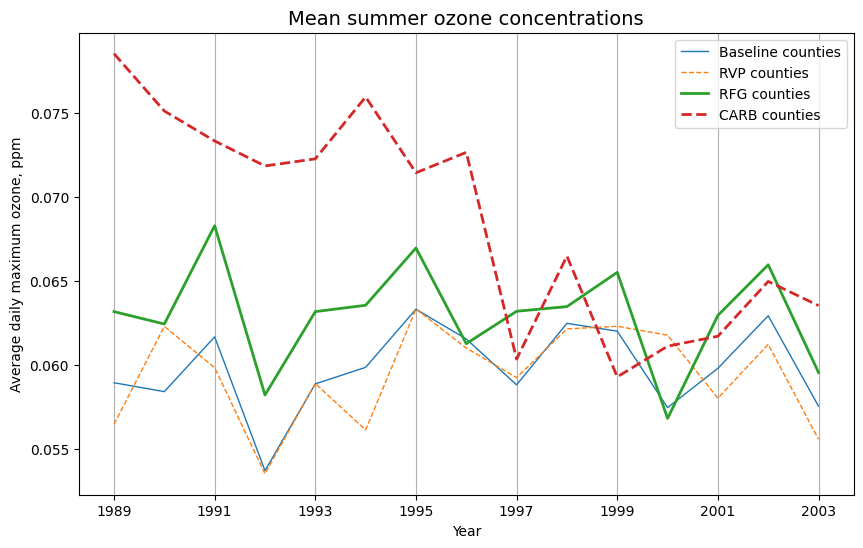

In [91]:
plt.figure(figsize=(10, 6))

county_labels = {
    0: {"label": "Baseline counties", "style": {"linestyle": "-", "linewidth": 1}},
    1: {"label": "RVP counties", "style": {"linestyle": "--", "linewidth": 1}},
    2: {"label": "RFG counties", "style": {"linestyle": "-", "linewidth": 2}},
    3: {"label": "CARB counties", "style": {"linestyle": "--", "linewidth": 2}}
}

for county_type, group in collapsed_data.groupby("CountyType"):
    plt.plot(
        group["year"], group["ozone_max"],
        label=county_labels[county_type]["label"],
        **county_labels[county_type]["style"]
    )

plt.title("Mean summer ozone concentrations", fontsize=14)
# plt.suptitle("Broken out by regulation type", fontsize=10)
plt.ylabel("Average daily maximum ozone, ppm")
plt.xlabel("Year")
plt.xticks(range(1989, 2004, 2))  # 自定义 x 轴刻度
plt.grid(axis='x')  # 只显示 x 轴的网格线

plt.legend()
plt.show()

PLOTS OF AVERAGE SUMMER RESIDUALS

In [20]:
data = pd.read_stata("DD_AnalysisDataset_Diffed.dta")
data['incomeD'] = data['incomeD']/1000000000
vars_all = genVars(['Temp','Rain','Snow','DOY','_D','_RW','_RD'], ['ozone_maxD', 'A_StateYear'])
data = data.loc[~data[vars_all].isna().any(axis=1), :]

formula = genFormula(['Temp','Rain','Snow','DOY','_D','_RW','_RD'], [], 'ozone_maxD', True)
model = ols(formula, data=data).fit(cov_type='cluster', cov_kwds={'groups': data['A_StateYear']})

data['O3_Resid'] = model.resid

data['CountyType'] = 0
data.loc[data['A_RVPCty'] == 1, 'CountyType'] = 1
data.loc[(data['A_RFGCty'] == 1) | (data['A_RVPRFGCty'] == 1), 'CountyType'] = 2
data.loc[(data['A_CARBCty'] == 1) | (data['A_CARBRFGCty'] == 1), 'CountyType'] = 3

grouped_data = data.groupby(['CountyType', 'A_year'], as_index=False).agg({
    'O3_Resid': 'mean'
})

grouped_data.rename(columns={'A_year': 'year'}, inplace=True)
grouped_data.to_stata("GraphData_Resids.dta")

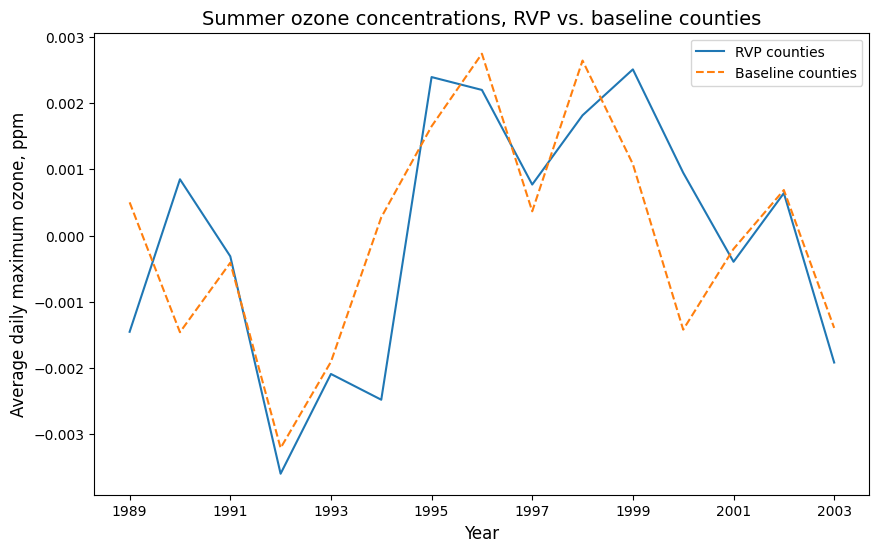

In [89]:
data = pd.read_stata("GraphData_Resids.dta")

data.sort_values(by=['CountyType', 'year'], inplace=True)

plt.figure(figsize=(10, 6))

rvp_data = data[data['CountyType'] == 1]
plt.plot(rvp_data['year'], rvp_data['O3_Resid'], label="RVP counties", linestyle='solid')

baseline_data = data[data['CountyType'] == 0]
plt.plot(baseline_data['year'], baseline_data['O3_Resid'], label="Baseline counties", linestyle='dashed')

plt.title("Summer ozone concentrations, RVP vs. baseline counties", fontsize=14)
# plt.suptitle("Values are averaged residuals after weather effects removed", fontsize=10)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average daily maximum ozone, ppm", fontsize=12)

plt.xticks(range(1989, 2004, 2))
plt.legend(title="", fontsize=10, labels=["RVP counties", "Baseline counties"])
plt.show()


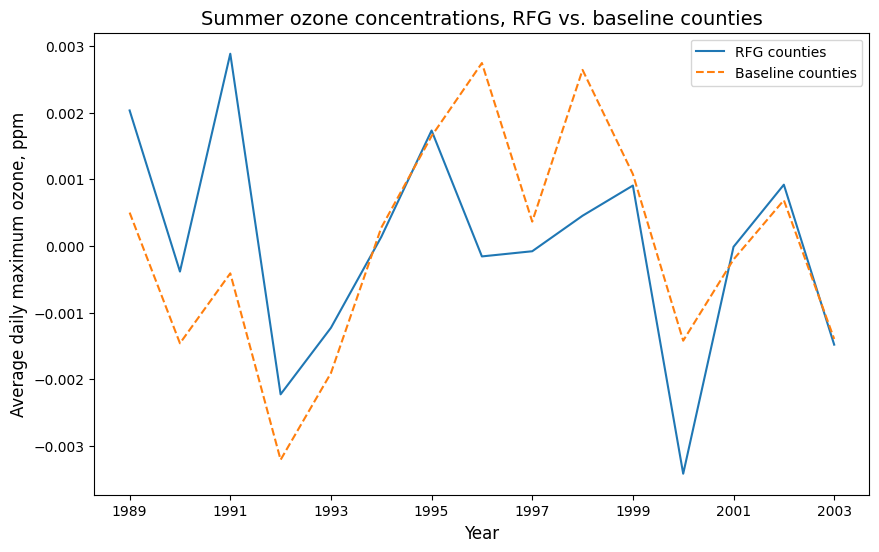

In [88]:
data = pd.read_stata("GraphData_Resids.dta")

data.sort_values(by=['CountyType', 'year'], inplace=True)

plt.figure(figsize=(10, 6))

rvp_data = data[data['CountyType'] == 2]
plt.plot(rvp_data['year'], rvp_data['O3_Resid'], label="RFG counties", linestyle='solid')

baseline_data = data[data['CountyType'] == 0]
plt.plot(baseline_data['year'], baseline_data['O3_Resid'], label="Baseline counties", linestyle='dashed')

plt.title("Summer ozone concentrations, RFG vs. baseline counties", fontsize=14)
# plt.suptitle("Values are averaged residuals after weather effects removed", fontsize=10)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average daily maximum ozone, ppm", fontsize=12)

plt.xticks(range(1989, 2004, 2))
plt.legend(title="", fontsize=10, labels=["RFG counties", "Baseline counties"])
plt.show()


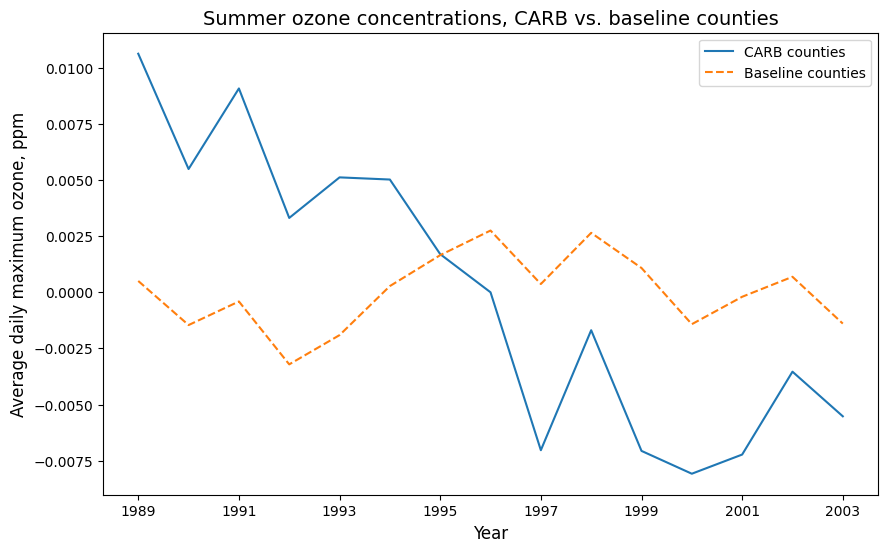

In [87]:
data = pd.read_stata("GraphData_Resids.dta")

data.sort_values(by=['CountyType', 'year'], inplace=True)

plt.figure(figsize=(10, 6))

rvp_data = data[data['CountyType'] == 3]
plt.plot(rvp_data['year'], rvp_data['O3_Resid'], label="CARB counties", linestyle='solid')

baseline_data = data[data['CountyType'] == 0]
plt.plot(baseline_data['year'], baseline_data['O3_Resid'], label="Baseline counties", linestyle='dashed')

plt.title("Summer ozone concentrations, CARB vs. baseline counties", fontsize=14)
# plt.suptitle("Values are averaged residuals after weather effects removed", fontsize=10)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average daily maximum ozone, ppm", fontsize=12)

plt.xticks(range(1989, 2004, 2))
plt.legend(title="", fontsize=10, labels=["CARB counties", "Baseline counties"])
plt.show()